<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/covidradio_weighted_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/data.zip

!wget https://bglpjmnr.labs.coursera.org/edit/M1/nih/densenet.hdf5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace data/test/COVID/COVID-672.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
--2021-08-23 09:57:56--  https://bglpjmnr.labs.coursera.org/edit/M1/nih/densenet.hdf5
Resolving bglpjmnr.labs.coursera.org (bglpjmnr.labs.coursera.org)... 54.82.207.198, 52.2.221.95
Connecting to bglpjmnr.labs.coursera.org (bglpjmnr.labs.coursera.org)|54.82.207.198|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://hub.labs.coursera.org:443/connect/bglpjmnr?forceRefresh=false [following]
--2021-08-23 09:57:56--  https://hub.labs.coursera.org/connect/bglpjmnr?forceRefresh=false
Resolving hub.labs.coursera.org (hub.labs.coursera.org)... 52.2.221.95, 54.82.207.198
Connecting to hub.labs.coursera.org (hub.labs.coursera.org)|52.2.221.95|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://www.coursera

In [8]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.layers import GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.applications.densenet import DenseNet121



#### Get metadata on training set 

In [ ]:
classes = ('normal', 'COVID')
data_path = 'data'

counts = []
filelists = []
for item in classes:
    filelist = os.listdir(os.path.join(data_path, 'train', item))
    filelists.append(filelist)
    counts.append(len(filelist))


#### Visualize samples of the image data by class

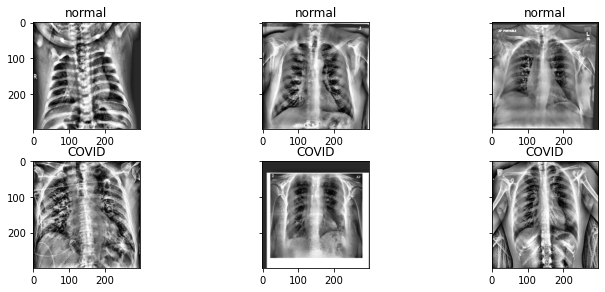

In [ ]:
f, axes = plt.subplots(len(classes), 3, sharey=True)
f.set_figwidth(10)
plt.tight_layout()

for i, item in enumerate(classes):
    images = random.sample(filelists[i], 3)
    for j, image in enumerate(images):
        img_file = os.path.join(data_path, 'train', item, image)
        img = plt.imread(img_file)
        axes[i][j].imshow(img, cmap='gray')
        axes[i][j].set_title(item)


#### Plot prevalence of classes

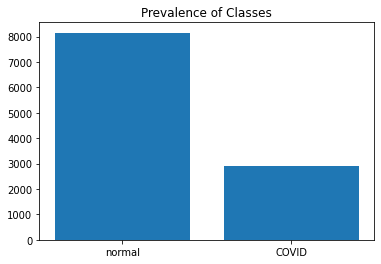

In [ ]:
plt.bar(classes, counts)
plt.title('Prevalence of Classes');

#### Data generators to import images into the classifier

In [21]:
datagen = ImageDataGenerator(rescale=1./255.)

train_path = os.path.join(data_path, 'train')
train_gen = datagen.flow_from_directory(directory=train_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

valid_path = os.path.join(data_path, 'valid')
valid_gen = datagen.flow_from_directory(directory=valid_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

test_path = os.path.join(data_path, 'test')
test_gen = datagen.flow_from_directory(directory=test_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

Found 11045 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


In [11]:

base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

#### Weighted binary crossentropy loss function

In [13]:
neg_w = np.sum(train_gen.classes) / len(train_gen.classes)
pos_w = 1 - neg_w

def Weighted_Loss(pos_w, neg_w, epsilon=1e-7):
  def weighted_loss(y_true, y_pred):
    pos_loss = -1 * K.mean(pos_w * y_true * K.log(y_pred + epsilon))
    neg_loss = -1 * K.mean(neg_w * (1 - y_true) * K.log(1 - y_pred + epsilon))
    loss = pos_loss + neg_loss
    return loss
  return weighted_loss

#### Compile and train

In [16]:
model.compile(loss=Weighted_Loss(pos_w, neg_w), optimizer='adam', metrics=['accuracy'])

stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.001)

history = model.fit(train_gen,
                    epochs=25,
                    validation_data=valid_gen,
                    verbose=1,
                    callbacks=[stop, reduce_lr])

Epoch 1/25
346/346 [==============================] - 441s 1s/step - loss: 0.0318 - accuracy: 0.9699
Epoch 2/25
346/346 [==============================] - 428s 1s/step - loss: 0.0216 - accuracy: 0.9799
Epoch 3/25
346/346 [==============================] - 428s 1s/step - loss: 0.0195 - accuracy: 0.9817
Epoch 4/25
346/346 [==============================] - 428s 1s/step - loss: 0.0168 - accuracy: 0.9834
Epoch 5/25
346/346 [==============================] - 423s 1s/step - loss: 0.0106 - accuracy: 0.9895
Epoch 6/25
346/346 [==============================] - 419s 1s/step - loss: 0.0247 - accuracy: 0.9746
Epoch 7/25
346/346 [==============================] - 419s 1s/step - loss: 0.0124 - accuracy: 0.9893
Epoch 8/25
346/346 [==============================] - 420s 1s/step - loss: 0.0084 - accuracy: 0.9927
Epoch 9/25
346/346 [==============================] - 419s 1s/step - loss: 0.0092 - accuracy: 0.9916
Epoch 10/25
346/346 [==============================] - 419s 1s/step - loss: 0.0073 - accura

In [ ]:
model_path = os.path.join(BASE_PATH, 'weighted_model.h5')
model.save(model_path)

#### Evaluate the model

(Accuracy is not everything.)

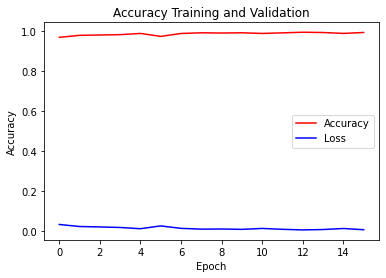

In [18]:
plt.plot(history.history['accuracy'], 'r', label='Accuracy')
plt.plot(history.history['loss'], 'b', label='Loss')
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [22]:
score = model.evaluate(valid_gen)
print(f'Accuracy Score = {round(score[1], 2) * 100}%')

44/44 [==============================] - 20s 408ms/step - loss: 0.0222 - accuracy: 0.9812
Accuracy Score = 98.0%


#### Calculate confusion matrix, precision, recall, f1

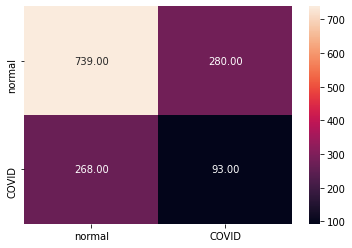

In [23]:
y_true = valid_gen.classes
y_pred = model.predict(valid_gen)
y_pred = y_pred.reshape(-1)
y_pred = y_pred > 0.5
cf = confusion_matrix(y_true, y_pred)
sns.heatmap(cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.2f');

In [25]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

      normal       0.73      0.73      0.73      1019
       COVID       0.25      0.26      0.25       361

    accuracy                           0.60      1380
   macro avg       0.49      0.49      0.49      1380
weighted avg       0.61      0.60      0.60      1380



#### ROC-AUC curve and AUC score

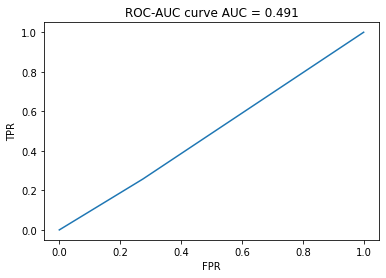

In [26]:
fpr, tpr, thresh = roc_curve(y_true, y_pred)
auc_score = round(roc_auc_score(y_true, y_pred), 3)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f'ROC-AUC curve AUC = {auc_score}')
plt.show()

#### Calculate Sensitivity, specificity, and PPV
Calculate PPV (Positive Predictive Value) using Bayes Theorem
 
 
$$ PPV = \frac{sensitivity \times prevalence}{sensitivity\times prevalence + (1 - specificty)\times(1 - prevalence)} $$

In [27]:
# tp, fp, tn, fn
tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
tn = np.sum((y_true == 0) & (y_pred == 0))
fn = np.sum((y_true == 1) & (y_pred == 0))

# sensitivity, specificity
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Accuracy = {round(accuracy * 100, 2)}%')
print(f'Sensitivity = {round(sensitivity * 100, 2)}%')
print(f'Specificity = {round(specificity * 100, 2)}%')
    
# Calculate PPV according to Bayes Theorem
prev = np.sum(y_true) / len(y_true)
numerator = sensitivity * prev
denominator = sensitivity * prev + (1 - specificity) * (1 - prev)
ppv = numerator / denominator
print(f'Positive Predictive Value = {round(ppv * 100, 2)}%')


Accuracy = 60.29%
Sensitivity = 25.76%
Specificity = 72.52%
Positive Predictive Value = 24.93%


$$ P^4 $$ 
#### (Pretty Piss Poor Performance)

But it is a baseline, and we are getting the metrics to be used worked out.